- trip end time should be in the same day
- count of trips
- avg mileage 
- avg trip_duration_seconds	
group by user_id and day
can we get the time distance between 2 trips  

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [81]:
df = pd.read_parquet('trip_summary_sept08.parquet')
print(df.shape)

(114090, 19)


In [82]:
df['trip_start_time'] = pd.to_datetime(df['trip_start_time_gmt'] ,  unit='s')
df['trip_end_time'] = pd.to_datetime(df['trip_end_time_gmt'] ,  unit='s')
df['trip_date'] = df['trip_end_time'].dt.date
# result = df.groupby(['user-id', 'trip_date'])['trip_mileage'].mean().reset_index()

C:\Users\mehrn\anaconda3\Lib\site-packages\pandas\core\tools\datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [83]:
# Python 3 program to calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))   
    # Radius of earth in miles
    r = 3956
    # calculate the result
    return(c * r)

In [84]:
# Calculate and store the trip mileage in a new column
df['trip_mileage'] = df.apply(
    lambda row: distance(row['trip_start_latitude'], row['trip_start_longitude'], row['trip_end_latitude'], row['trip_end_longitude']),
    axis=1)

In [85]:
unique_user_count = df['device_id'].nunique()
print(unique_user_count)

938


In [18]:
features = [
 "trip_start_time_gmt",
 "trip_end_time_gmt",
 "trip_start_latitude",
 "trip_start_longitude",
 "trip_end_latitude",
 "trip_duration_seconds",
 "trip_end_longitude",
 ]
features

['trip_start_time_gmt',
 'trip_end_time_gmt',
 'trip_start_latitude',
 'trip_start_longitude',
 'trip_end_latitude',
 'trip_duration_seconds',
 'trip_end_longitude']

In [19]:
df = df.dropna(subset = features)

In [20]:
# Group by 'user-id' and 'date', then calculate the required statistics
results = df.groupby(['device_id', 'trip_date']).agg({'trip_mileage': 'sum', 'trip_id': 'count', 'trip_duration_seconds': 'sum'}).reset_index()
results = results.rename(columns={'trip_mileage': 'total_mileage', 'trip_id': 'trip_count', 'trip_duration_seconds': 'total_trip_duration'})

In [21]:
results

,user_id,trip_date,total_mileage,trip_count,total_trip_duration
0,1000018963,2023-03-20,47.008533,21,17820
1,1000018963,2023-03-21,8.205399,12,6960
2,1002329,2023-05-19,39.509738,5,7068
3,1002329,2023-05-20,48.526633,8,8436
4,1002329,2023-05-22,37.002437,3,7104
...,...,...,...,...,...
20816,971996,2023-05-31,11.986519,5,4542
20817,996700,2023-07-25,15.095664,2,3204
20818,996700,2023-07-26,1.928848,1,1056
20819,996700,2023-07-30,19.565552,1,2154


In [24]:
features = ["total_mileage" , "trip_count", "total_trip_duration"]
features

['total_mileage', 'trip_count', 'total_trip_duration']

In [27]:
data = results[features].copy()
print(data.shape)

(20821, 3)


STEPS:
1. Scale data to standardize values
2. Initialize random centroids
3. Get labels for each data point
4. Create new centroids
5. Plot the centroids
6. Repeat 3-5 until the centroids stop changing

In [29]:
scale_vars = ['total_mileage', 'trip_count', 'total_trip_duration']
scaler = MinMaxScaler()
data[scale_vars] = scaler.fit_transform(data[scale_vars]) * 10 + 1
data.head()

,total_mileage,trip_count,total_trip_duration
0,1.066684,2.980198,2.579283
1,1.011640,2.089109,1.616824
2,1.056047,1.396040,1.626396
3,1.068838,1.693069,1.747634
4,1.052490,1.198020,1.629586


In [30]:
data.describe()

,total_mileage,trip_count,total_trip_duration
count,20821.000000,20821.000000,20821.000000
mean,1.053067,1.398560,1.575434
std,0.114502,0.423579,0.609239
min,1.000000,1.000000,1.000000
25%,1.008488,1.099010,1.199936
50%,1.025138,1.297030,1.403063
75%,1.060611,1.495050,1.727959
max,11.000000,11.000000,11.000000


In [31]:
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [32]:
centroids = random_centroids(data, 3)
centroids

,0,1,2
total_mileage,1.029001,1.032283,1.000014
trip_count,1.198020,1.990099,1.594059
total_trip_duration,1.150484,1.267468,1.305753


In [33]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [34]:
labels = get_labels(data, centroids)

In [35]:
labels.value_counts()

0    10758
2     7921
1     2142
dtype: int64

In [38]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [40]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

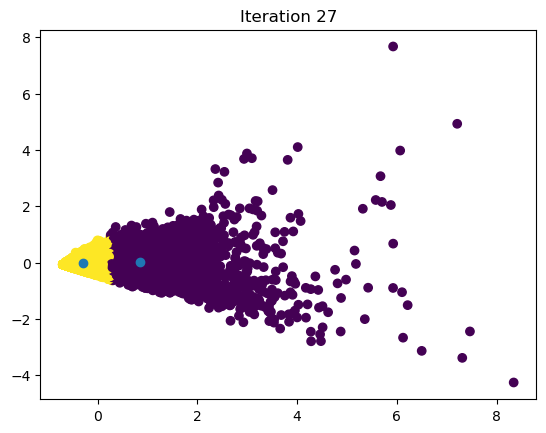

In [41]:
max_iterations = 100
centroid_count = 2

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [42]:
centroids

,0,1
total_mileage,1.134808,1.026338
trip_count,1.839747,1.237853
total_trip_duration,2.309138,1.321483


In [43]:
labels.value_counts()

1    16176
0     4645
dtype: int64

In [44]:
results[labels == 1][["device_id"] + features]

,user_id,total_mileage,trip_count,total_trip_duration
2,1002329,39.509738,5,7068
4,1002329,37.002437,3,7104
7,1002329,29.250780,3,8304
8,1002329,28.726352,3,3984
9,1002329,86.311957,2,9492
...,...,...,...,...
20816,971996,11.986519,5,4542
20817,996700,15.095664,2,3204
20818,996700,1.928848,1,1056
20819,996700,19.565552,1,2154


In [45]:
results[labels == 0][["device_id"] + features]

,user_id,total_mileage,trip_count,total_trip_duration
0,1000018963,47.008533,21,17820
1,1000018963,8.205399,12,6960
3,1002329,48.526633,8,8436
5,1002329,50.175308,10,14244
6,1002329,46.353913,5,10230
...,...,...,...,...
20805,944145,154.419542,7,17244
20809,944145,188.702843,12,32790
20810,944145,122.675528,14,25836
20811,944145,83.628062,11,13716


In [46]:
from sklearn.cluster import KMeans

In [47]:
kmeans = KMeans(3)
kmeans.fit(data)

C:\Users\mehrn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [49]:
pd.DataFrame(kmeans.cluster_centers_, columns=features).T


,0,1,2
total_mileage,1.299557,1.021971,1.085911
trip_count,2.324688,1.206692,1.700141
total_trip_duration,3.565573,1.285630,1.932606
